In [8]:
import os
import cv2
import pytesseract
from PIL import Image
import pandas as pd
import numpy as np
import easyocr
import csv
import json

## **Function #1** : Create the dictionaries 

In [44]:
def dict_function(img_name,title,valeo_id,filters_boxes,ocr_bounding,ocr):
    dict = {'img_name':img_name,
            'title':title,
            'valeo_Id':valeo_id,
            'bounding_boxes':filters_boxes,
            'ocr_bounding_boxes':ocr_bounding,
            'ocr':ocr}
    
    return dict
    

## **Function** : convert lists to json serialized

In [45]:
def json_serialized(list):
    # Create an empty list to store the converted lists
    converted_list = []

    # Loop through the original list
    for sublist in list:
        converted_sublist = []  # Create a sublist for converted values
        for point in sublist:
            converted_point = [int(coord) for coord in point]  # Convert each coordinate to int
            converted_sublist.append(converted_point)  # Add the converted point to the sublist
        converted_list.append(converted_sublist)  # Add the converted sublist to the final list

    # Serialize the converted list of lists using json.dumps
    ocr_boxes = json.dumps(converted_list)
    
    return ocr_boxes

## **Function #2** : OCR processing 

In [46]:
def ocr(img_path):
    #Initialzing the ocr
    text_reader = easyocr.Reader(['en']) 
    
    # Open the image using OpenCV
    image = cv2.imread(img_path)

    # Perform OCR on the image
    extracted_text = text_reader.readtext(image)
    
    # Extract bounding boxes and merge texts
    bounding_boxes = []
    merged_text = ""

    for box, text, confidence in extracted_text:
        bounding_boxes.append(box)
        merged_text += text + " "

    # Remove trailing space from merged_text
    merged_text = merged_text.strip()
    
    return bounding_boxes , merged_text
    
    

## **Function #3** : Yellow filter

In [47]:
def yellow_filter(img_path):
    
    # initialize a list to store bounding boxes 
    boxes = []
    
    # Load the image
    image = cv2.imread(img_path)
    
    # Convert BGR image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  
    # Define the lower and upper bounds for yellow color
    lower_yellow = np.array([35, 100, 100])
    upper_yellow = np.array([85, 255, 255])

    # Create a mask for yellow pixels
    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Bitwise-AND mask and original image
    yellow_objects = cv2.bitwise_and(image, image, mask=yellow_mask)

    # Convert the green objects image to grayscale
    gray_yellow = cv2.cvtColor(yellow_objects, cv2.COLOR_BGR2GRAY)

    # Find contours in the grayscale image
    contours, _ = cv2.findContours(gray_yellow, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding boxes around the detected contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w and h >= 25:
            box = (x,y,w,h)
            boxes.append(box)
    
    return boxes  

## **Function #4** : Green filter

In [48]:
def green_filter(img_path):
    
    # initialize a list to store bounding boxes 
    boxes = []
    
    # Load the image
    image = cv2.imread(img_path)
    
    # Convert BGR image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  
    # Define the lower and upper bounds for green color
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])

    # Create a mask for green pixels
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

    # Bitwise-AND mask and original image
    green_objects = cv2.bitwise_and(image, image, mask=green_mask)

    # Convert the green objects image to grayscale
    gray_green = cv2.cvtColor(green_objects, cv2.COLOR_BGR2GRAY)

    # Find contours in the grayscale image
    contours, _ = cv2.findContours(gray_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding boxes around the detected contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w and h >= 25:
            box = (x,y,w,h)
            boxes.append(box)
    
    return boxes  

## **Function #5** : Red filter

In [49]:
def red_filter(img_path):
    
    # initialize a list to store bounding boxes 
    boxes = []
    
    # Load the image
    image = cv2.imread(img_path)
    
    # Convert BGR image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Adjusted lower and upper bounds for red
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])

    # Create a mask for red pixels
    red_mask = cv2.inRange(hsv_image, lower_red, upper_red)

    # Bitwise-AND mask and original image
    red_objects = cv2.bitwise_and(image, image, mask=red_mask)

    # Convert the red objects image to grayscale
    gray_red = cv2.cvtColor(red_objects, cv2.COLOR_BGR2GRAY)

    # Find contours in the grayscale image
    contours, _ = cv2.findContours(gray_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw bounding boxes around the detected contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w and h >= 25:
            box = (x,y,w,h)
            boxes.append(box)
    
    return boxes        

## **Function #6** : Images pipeline

In [50]:
def img_pipeline(img_path):
    
    # Initialize list to store all filters bounding boxes
    all_filter_boxes=[]
    
    # process image for ocr 
    ocr_boxes , text = ocr(img_path)
    ocr_boxes = json_serialized(ocr_boxes)
    
    
    # Red filter
    red_boxes = red_filter(img_path)
    all_filter_boxes.append(red_boxes)
    
    # Yellow filter
    yellow_boxes = yellow_filter(img_path)
    all_filter_boxes.append(yellow_boxes)

    # Green filter
    green_boxes = green_filter(img_path)
    all_filter_boxes.append(green_boxes)
    
    # Make the list in json form
    all_filter_boxes = json.dumps(all_filter_boxes)
    
    return text , ocr_boxes , all_filter_boxes

    

## **Function #7** : Main function

In [51]:
def main(imgs_dir,df_dir):
    df = pd.read_excel(df_dir)
    data = []
    for index in range(100):
        img_path = imgs_dir + df['alt_text'][index]
        ocr_text, ocr_boxes , filters_boxes = img_pipeline(img_path)
        img_name = df['alt_text'][index]
        valeo_id = df['Valeo Id'][index]
        title = df['title'][index]
        img_data = dict_function(img_name,title,valeo_id,filters_boxes,ocr_boxes,ocr_text)
        data.append(img_data)
    
    # Create a DataFrame from the list of dictionaries
    df_all = pd.DataFrame(data)

    # Specify the Excel file name
    excel_file = 'fitting_instruction_final.xlsx'

    # Save the DataFrame to the Excel file
    df_all.to_excel(excel_file, index=False, engine='openpyxl')    

## Start the program ✔

In [52]:
main('fitting_instruction_imgs/','created_csv/fitting_instruction_new.xlsx')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster wi

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
def test(index):
    test_df = pd.read_excel('fitting_instruction_final.xlsx')
    name = test_df['img_name'][index]

    print(name)

    path = 'fitting_instruction_imgs/' + name
    # Load the image
    # image_path = 'your_image.jpg'  # Replace with your image file path
    image = plt.imread(path)

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Define the bounding box coordinates
    bbox = json.loads(test_df['ocr_bounding_boxes'][index])
    # Create a Rectangle patch
    for box in bbox:
        rect = patches.Polygon(box, closed=True, edgecolor='b', facecolor='none')

        # Add the Rectangle patch to the axis
        ax.add_patch(rect)


    bounding_boxes = json.loads(test_df['bounding_boxes'][index])
    for box in bounding_boxes:
        
        if not box:  # Skip empty boxes
            continue
        
        if len(box) == 1:
            box = box[0]  # Get the inner list

        if len(box) == 4:    
            x1, y1, x2, y2 = box
            # Create a rectangle patch
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
            # Add the patch to the figure
            ax.add_patch(rect)


    # Show the image with the bounding box
    plt.show()


828128-1.JPG


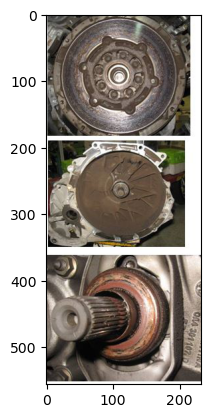

In [30]:
test(32)